# Cats Vs. Dogs

The dataset we will discuss in this notebook is the "Cats vs. Dogs" Dataset. It contains 25000 images of cats and dogs (12500 of cats and 12500 of dogs). The images are coloured, and of varying sizes. The data also contains a test set of images, but due to them not having labels for us to check ourselves, we will not take notice of it, but rather divide the labeled data into a training and testing set. The testing set will be used only in the final section of the notebook, after the best classifier for the data has been discovered. The purpose of the notebook is to classify a previously unseen image as a cat or a dog.

#### How shall we achieve the result?

We receive the images as a .zip file, containing a folder with images. Most of the work as I see it is to transform the images into data that the classifier can understand (numeric). As each image is colored, then each pixel of the image contains 3 to 4 values (red, green, blue, alpha) - in the case of our images it is 3 (without the alpha). Thus, a picture with the dimensions of 500X500 (for example) has 250000 pixels, each containing 3 values (in total 750000 values). That is a lot of data for the computer to go through even for one image, and we have 25000 of those.<br>
As such, our primary objective is to reduce the amount of data each classifier has to comb through to achieve the end result. We shall do this by first removing the RGB values from the image (transforming them to grayscale), as the color the not contribute much to the determination of whether the image is of a cat or a dog, and by removing it, we shrink the data volume by three times.<br>
Next, we wish to transform the images into a dataframe, due to the classifiers not being able to (by themselves) work on raw images. To do that, we have to transform each image (which can be shown as a 2D array) into a 1D array, and each record of the new dataframe shall be an image thus transformed.

As the image database is far too large to import to GitHub, we shall not do so. The images were taken and can be downloaded from Kaggle.com at the link:
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

<b>Note:</b> This notebook was created as a brand-new notebook, with no regard to previous notebooks written, so all explanations regarding actions done and classifiers used (when applicable) is the same as in previous notebooks (some parts were copied and only the parts that are unique to this notebook have been changed, such as why one hyperparameter was set to one specific value and not another).

In [11]:
#Relevant imports
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import time
from sklearn import metrics
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB

## Loading Data and Pre-Processing

### Loading and Preparing Data

Below, we load the data from the folder of the cats and dogs images. As the label of each image is in its title ('cat' or 'dog' followed by a number. Hence, to determine if an image is of a dog or a cat, we have to only search for the appropriate string in the image name. We then save the images as a list: one for dogs and one for cats.

In [6]:
TRAIN_DIR = 'Data/Cats vs Dogs/train/'

trainDogsPathList = [TRAIN_DIR+ dog_file_name for dog_file_name in os.listdir(TRAIN_DIR) if 'dog' in dog_file_name]
trainCatsPathList = [TRAIN_DIR+ cat_file_name for cat_file_name in os.listdir(TRAIN_DIR) if 'cat' in cat_file_name]

Below we plot some sample pictures of both cats and dogs using the OpenCV library and matplotlib. First, we show the images with color, then some images transformed to grayscale.

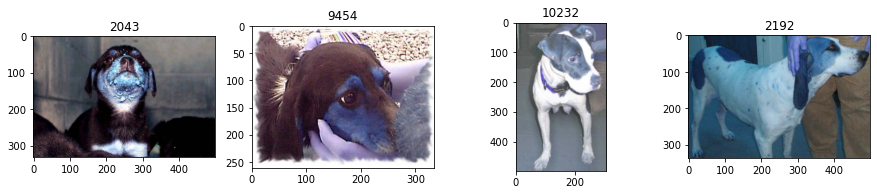

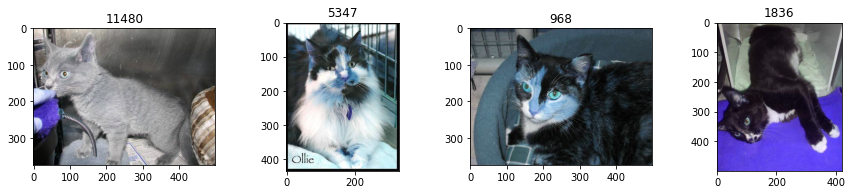

In [7]:
def showPics (list, colOrGray):
    fig = plt.figure(figsize=(15,6))
    for i in range(1,5):
        rand= random.randint(0, 12500)
        img = list[rand]
        img_array = cv2.imread(img, colOrGray)
        ax=fig.add_subplot(2,4,i)
        ax.title.set_text(rand)
        plt.imshow(img_array, cmap = 'gray')
showPics(trainDogsPathList, cv2.IMREAD_COLOR)
showPics(trainCatsPathList, cv2.IMREAD_COLOR)

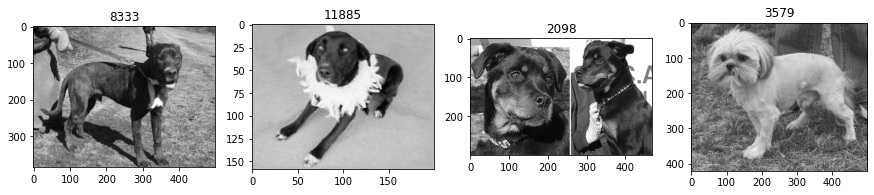

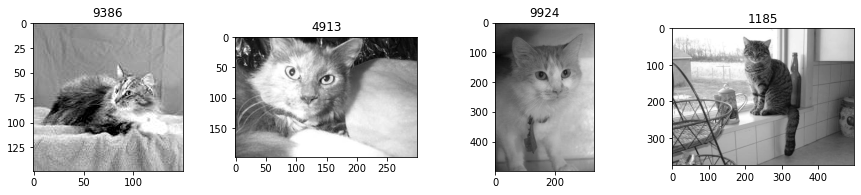

In [8]:
showPics(trainDogsPathList, cv2.IMREAD_GRAYSCALE)
showPics(trainCatsPathList, cv2.IMREAD_GRAYSCALE)

We can see below that the shape of each image (coloured) is a 3D array of some shape when the last value is always 3 (standing for RGB). As we wish to transform the lot of images to a 2D dataframe, we must have it so that each image is a 1D array.

In [9]:
img = trainDogsPathList[0]
img_array = cv2.imread(img, cv2.IMREAD_COLOR)
print(img_array.shape)

(375, 499, 3)


All images in the dataframe are of different sizes, so when we shall push them into a dataset without changing them first, the dataset will contain many NaN values, which is not an ideal situation at best. To avoid such a situation, and also to shrink the size of the output dataframe, we shall resize each image to an image of 100 X 100 pixels. Below we show how such images will look when transformed:

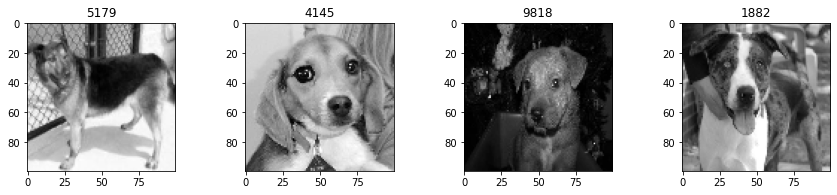

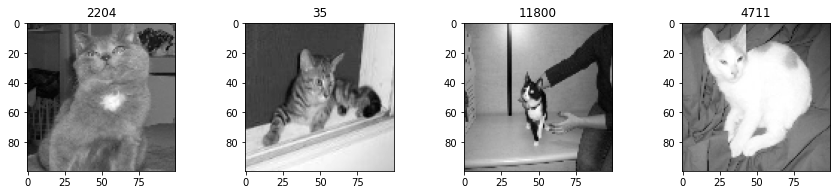

In [10]:
def showResizedPics (list, colOrGray):
    fig = plt.figure(figsize=(15,6))
    for i in range(1,5):
        rand= random.randint(0, 12500)
        img = list[rand]
        img_array = cv2.imread(img, colOrGray)
        img_array = cv2.resize(img_array,(100,100))
        ax=fig.add_subplot(2,4,i)
        ax.title.set_text(rand)
        plt.imshow(img_array, cmap = 'gray')
showResizedPics(trainDogsPathList, cv2.IMREAD_GRAYSCALE)
showResizedPics(trainCatsPathList, cv2.IMREAD_GRAYSCALE)

## Images in Grayscale

To push all images into a single dataframe so that we can start the "real work", we shall first define two dataframes with 10000 columns (100*100)

In [11]:
list = []
for i in range(100*100):
    list.append(i)
dfDogs = pd.DataFrame(columns=list)
dfCats = pd.DataFrame(columns=list)
dfDogs

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999


We next construct a function which does the actual work: given a dataframe and a name ('cat' or 'dog') the function goes over the appropriate list of filepaths, resizes the image to 100 by 100, transforms it into grayscale (resulting in a 2D array of 100 by 100 of pixel grayscale values), reshapes the 2D array into a 1D array using the .ravel() function, adds an appropriate label to the dataframe (0 for cat and 1 for dog), pushes the array as a record into the dataframe and finally returns the dataframe.<br>
We run the function twice - once for cats and once for dogs, storing the data in the appropriate dataframe.

In [12]:
def toDF (df, name, bwOrColor, dimentionX, dimentionY):
    for i in range (0, len(trainDogsPathList)):
        if (name == 'cat'):
            imgPath = trainCatsPathList[i]
        if (name == 'dog'):
            imgPath = trainDogsPathList[i]
        imgArray = cv2.imread(imgPath, bwOrColor)
        imgArray = cv2.resize(imgArray, (dimentionX, dimentionY))
        imgArray = imgArray.ravel()
        df.loc[i] = imgArray
    if (name == 'cat'):
        df['Dog/Cat'] = 0
    if (name == 'dog'):
        df['Dog/Cat'] = 1
    return df

In [19]:
dfDogs = toDF (dfDogs, 'dog', cv2.IMREAD_GRAYSCALE, 100, 100)
dfCats = toDF (dfCats, 'cat', cv2.IMREAD_GRAYSCALE, 100, 100)

At the end of the function, both dataframes contain 12500 records and 10001 features (10000 for the pixels and 1 for the label):

In [20]:
dfDogs

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Dog/Cat
0,119,109,152,160,160,165,130,134,136,124,...,80,76,77,74,70,70,69,88,75,1
1,146,120,124,132,101,105,53,96,112,78,...,250,255,248,246,243,242,240,239,237,1
2,118,109,93,98,101,123,125,116,120,126,...,95,95,96,93,93,94,92,94,94,1
3,185,184,186,183,183,181,182,183,184,185,...,58,78,84,80,59,65,59,69,71,1
4,16,7,7,7,23,52,63,45,77,40,...,103,107,114,109,126,124,123,116,116,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,140,143,142,145,146,147,148,149,148,149,...,165,166,166,167,168,168,168,168,169,1
12496,117,78,102,83,101,113,69,85,86,86,...,97,77,100,84,77,85,93,94,74,1
12497,42,35,47,58,65,46,51,57,58,40,...,133,130,125,70,113,182,127,113,167,1
12498,254,251,245,234,224,207,189,144,112,75,...,102,107,114,111,111,107,116,114,121,1


Next, we merge the 2 datasets of cats and dogs to form a general dataset of images with 25000 records using the concat() function. Slightly correcting the data by  removing the additional index added as a result of merging the datasets. 

In [13]:
def mergeDF(df1, df2):
    df = pd.concat([df1, df2])
    df.index.name = 'i' #renaming the index column so that the new index will not have the same name as the old
    df = df.reset_index()
    df = df.drop(['i'], axis = 1)
    return df

df = mergeDF(dfDogs, dfCats)

### Exporting df to .csv

Due to the process of transferring the images to a dataset taking a long time, we want to export the dataframe received to a .csv file on the local disk to reduce runtime on future runs of the program.

In [22]:
df.to_csv('Data/Cats vs Dogs/dfBW.csv')

### Loading .csv to df from Local Disc

When loading the df saved, the indexes are reset (unimportant), but the indexes from the saved file remain, so we remove them, resulting in the same dataframe as before the save.

In [2]:
df = pd.read_csv('Data/Cats vs Dogs/dfBW.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Dog/Cat
0,119,109,152,160,160,165,130,134,136,124,...,80,76,77,74,70,70,69,88,75,1
1,146,120,124,132,101,105,53,96,112,78,...,250,255,248,246,243,242,240,239,237,1
2,118,109,93,98,101,123,125,116,120,126,...,95,95,96,93,93,94,92,94,94,1
3,185,184,186,183,183,181,182,183,184,185,...,58,78,84,80,59,65,59,69,71,1
4,16,7,7,7,23,52,63,45,77,40,...,103,107,114,109,126,124,123,116,116,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24,22,21,21,21,21,19,20,20,19,...,69,81,80,72,84,70,80,71,74,0
24996,101,96,93,92,92,92,88,98,97,99,...,104,103,103,103,101,101,100,103,99,0
24997,96,98,97,97,97,107,96,94,94,100,...,254,254,254,254,254,254,254,254,254,0
24998,57,53,48,107,144,152,158,158,159,161,...,198,203,211,219,225,229,221,218,216,0


### Chacking for NaN values

To make sure that our classifiers will work correctly, we need to check if any of the values of the dataframe are NaN. As shown below, there are none, so we can continue on.

In [3]:
print("There are", df.isna().sum().sum(), "NaN values")

There are 0 NaN values


### Data Splitting

Now that or data is clean, we can split the data into x and y: the features given to each classifier and the labels.

In [4]:
x = df.drop(['Dog/Cat'], axis = 1)
y = df['Dog/Cat']

So as not to introduce bias to our program, our classifiers and all other actions performed on the data, we shall now split the data into a training and testing set. As we do not want to introduce bias when constructing and tuning our classifiers, we wish to not touch the testing set right up to the end, after the best classifier was chosen, we shall split the training set itself into a training and testing set (can also be called validation set), on which we shall run and tune our classifiers. We choose the size of both testing sets to be 10% of the data from which it splits, as the 10% are, in my opinion, enough to determine the quality of the classifiers.

In [5]:
X_train_Total, X_test_Final, y_train_Total, y_test_Final = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_train_Total, y_train_Total,
                                                                test_size = 0.1, random_state = 0)

### Removing Duplicates

We need to check that the training set does not contain duplicates (all feature values are the same), as they are not helpful for the classifiers. When found, the duplicates can be safely removed. This is run on the training set and was not done before the split into training and testing sets because in theory, the same image as the one the classifiers were trained on can be given to the classifier to test and return an answer on whether the image is that of a cat or a dog. Hence, the duplicates should be removed only from the training set, and not from the validation set or from the test set.<br>
This is done by first merging the X_train and the y_train so that when duplicates are found, they are removed together with the label, otherwise the record will be removed from X_train and not removed from y_train, thus leaving different dimensions than the ones needed for the classifiers.

In [7]:
def removeDuplicates(X_train, y_train):
    warnings.filterwarnings('ignore')
    x = X_train
    x['y'] = y_train

    x = x.drop_duplicates()

    X_train = x.drop(['y'], axis = 1)
    y_train = x['y']
    return X_train, y_train

X_train, y_train = removeDuplicates(X_train, y_train)

### Scaling

Next, we need to normalize our data, meaning transforming every value of 1-255 (the possible grayscale values of each pixel) to values in the range [0, 1]. We accomplish this by because most (if not all) classifiers expect and work best on such values from 0 to 1. This is done using the MinMaxScaler() method. The scaling is fitted to the train data, then both the train and the test data are transformed according to what was fitted.<br>
Note: standardization was not used instead, because the data we are evaluating does not have any outliers, so we need not concern ourselves with them (all values range from 0 to 255).

In [8]:
def scale(X_train, X_test, X_test_Final):
    min_max_scaler = MinMaxScaler()
    X_train = pd.DataFrame(min_max_scaler.fit_transform(X_train.values)) #fitting and transforming on train data
    X_test = pd.DataFrame(min_max_scaler.transform(X_test.values)) #only transforming the test and validation sets
    X_test_Final = pd.DataFrame(min_max_scaler.transform(X_test_Final.values))
    return X_train, X_test, X_test_Final

X_train, X_test, X_test_Final = scale(X_train, X_test, X_test_Final)

### PCA

<b>Dimensionality Reduction:</b><br>
When working with data which has many dimensions, it is often wise to attempt to quicken the classifiers by reducing the number of dimensions used to fit the data. Clearly, the removal of some dimensions will cause the classifier to perform worse than if it were run on the full data, but it can be very beneficial due to it expediting the runtime of the program dramatically. The problem occurs when we try to choose which dimensions to remove from examination, as it could be the feature having a crucial impact on the results of our classifier. This is what the PCA attempts to help us choose.

<b>What is PCA?</b><br>
The PCA algorithm attempts to help us use dimensionality reduction to reduce runtime while slightly reducing the accuracy of the classifiers. Using some linear algebra, the algorithm chooses the number of dimensions (as can be specified using the n_components hyperparameter) which are the most useful for the classifiers. When n_components is set to a value between 0 and 1, the algorithm covers the percentage of variance specified (very useful, as it is making the PCA flexible for different data, or for approximating the accuracy drop of the final classifier).

The PCA should be trained and fitted on the training set, and then the trained PCA should be used to transform the training, the validation, and the testing sets. Training the PCA on the test and validation sets is not right, as it means that we are using both the training and testing to fit the data to a certain shape, while analyzing it as a whole, which is incorrect, as the test and validation sets should only be used to test the results.
Despite that, the test and validation sets still has to be changed according to what the PCA has fitted on the training set, due to all classifiers requiring the data to be of the same shape in order to work on them.

In [9]:
def PCAFunc(X_train, X_test, X_test_Final):
    pca = PCA(n_components=0.9)
    X_train_Reduced = pd.DataFrame(pca.fit_transform(X_train))
    X_test_Reduced = pd.DataFrame(pca.transform(X_test))
    X_test_Final_Reduced = pd.DataFrame(pca.transform(X_test_Final))
    return X_train_Reduced, X_test_Reduced, X_test_Final_Reduced

X_train_Reduced, X_test_Reduced, X_test_Final_Reduced = PCAFunc(X_train, X_test, X_test_Final)

We can see that the amount of records in the training set has not changes, whereas the number of features has dropped drastically from 10000 to 335! That is only a small fraction of of the amount of features before the use of PCA, which still result in a relatively good accuracy score.

In [31]:
X_train_Reduced.shape

(20246, 335)

## Classifiers

For Each classifier, besides the explanation as to how the classifier performs its job (briefly), a confusion matrix and a classification report are added in order to help us judge the classifier's performance. What exactly the matrix and the report show us is explained in detail in the "Airline Satisfaction" notebook.

### Dummy Classifier

Before choosing and applying the models to the data, we need a baseline classifier, to compare all others to it: if the classifiers thereafter are worse than the base classifier, we are doing something wrong. If the classifier is better than the base classifier, on the other hand, it means that the model works, and can be better at predicting than a "dummy" classifier. The base classifier we will use is <b>Dummy Classifier</b>, which will, regardless of the input, put in the most frequent value in y_train. It puts in the most frequent value due to the strategy we have put into the model, although we could choose differently, but this strategy seems to return the best results.

In [12]:
#Dummy
start_timeDummy = time.time()
dummyModel = DummyClassifier(strategy="most_frequent")
dummyModel.fit(X_train_Reduced, y_train)
predictionsDummy = dummyModel.predict(X_test_Reduced)

accuracyDummy = metrics.accuracy_score(y_test, predictionsDummy)
print("Accuracy (KNN): ", accuracyDummy)
timeDummy = time.time() - start_timeDummy
print("Time taken to achive result: %s seconds" % (timeDummy))

Accuracy (KNN):  0.49377777777777776
Time taken to achive result: 0.34319186210632324 seconds


              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1111
           1       0.00      0.00      0.00      1139

    accuracy                           0.49      2250
   macro avg       0.25      0.50      0.33      2250
weighted avg       0.24      0.49      0.33      2250



<AxesSubplot:>

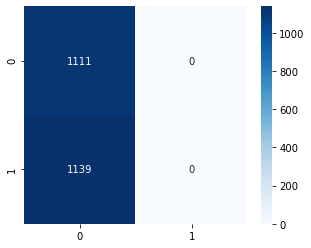

In [13]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsDummy, zero_division = 0))
sns.heatmap(confusion_matrix(y_test, predictionsDummy), cmap = "Blues", annot=True, fmt = '.0f')

### KNN Classifier

We will first use the <b>KNN classifier</b>. The KNN classifier (K nearest Neighbors) is one that chooses the value closest to the values from the train set. if K = 1, then it chooses depending on the single closest neighbor to the wanted data; if N > 1, then it chooses the label depending on the N closest neighbors (in terms of data). The "weights" parameter specifies whether the model is to give a higher penalty for the neighbors further away or to count their value as equally valuable to determine the label.

In [14]:
#KNN
start_timeKNN = time.time()
modelKNN = KNeighborsClassifier(n_neighbors = 15, weights='distance')
modelKNN.fit(X_train_Reduced, y_train)
predictionsKNN = modelKNN.predict(X_test_Reduced)
accuracyKNN = metrics.accuracy_score(y_test, predictionsKNN)
print("Accuracy (KNN): ", accuracyKNN)
timeKNN = time.time() - start_timeKNN
print("Time taken to achive result: %s seconds" % (timeKNN))

Accuracy (KNN):  0.5782222222222222
Time taken to achive result: 0.7063870429992676 seconds


              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1111
           1       0.58      0.58      0.58      1139

    accuracy                           0.58      2250
   macro avg       0.58      0.58      0.58      2250
weighted avg       0.58      0.58      0.58      2250



<AxesSubplot:>

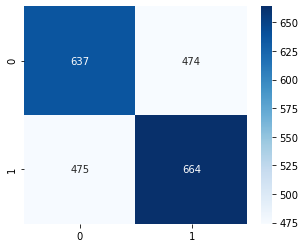

In [15]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsKNN))
sns.heatmap(confusion_matrix(y_test, predictionsKNN), cmap = "Blues", annot=True, fmt = '.0f')

### Logistic Regression Classifier

For our second classifier we will choose <b>Logistic Regression</b>. This classifier is chosen because it makes no assumptions regarding the distribution of labels, it works according to probabilities which it calculates for each record in the dataframe, and it is a fairly simple classifier that yet works well with many datasets. The classifier tries to fit an S shape to the data (as opposed to linear regression that fits a straight line), where the edges of the S are values where the probability is very high for a label to occur, and closer to the middle of the S, it is lower. We can also set a threshold "on the S", from which the classifier will predict a certain value. This is usually done when a certain value is preferred over the other. As we try to be objective with the reviews, we will not do it.

In [16]:
#Logistic Regression
start_timeLogReg = time.time()
modelLogReg = LogisticRegression()
modelLogReg.fit(X_train_Reduced, y_train)
predictionsLogReg = modelLogReg.predict(X_test_Reduced)
accuracyLogReg = modelLogReg.score(X_test_Reduced, y_test)
print("Accuracy (Logistic Regression): ", accuracyLogReg)
timeLogReg = time.time() - start_timeLogReg
print("Time taken to achive result: %s seconds" % (timeLogReg))

Accuracy (Logistic Regression):  0.5546666666666666
Time taken to achive result: 0.6389014720916748 seconds


              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1111
           1       0.56      0.54      0.55      1139

    accuracy                           0.55      2250
   macro avg       0.55      0.55      0.55      2250
weighted avg       0.55      0.55      0.55      2250



<AxesSubplot:>

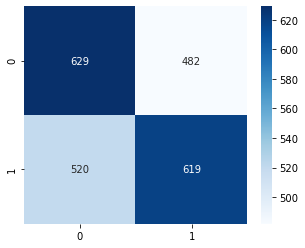

In [17]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsLogReg))
sns.heatmap(confusion_matrix(y_test, predictionsLogReg), cmap = "Blues", annot=True, fmt = '.0f')

### Gaussian Naive Bayes

Before we start with the models using Ensemble learning though, we would like to try using a classifier called <b>Gaussian Naive Bayes</b>. This classifier uses the Gaussian distribution to help it classify records. By calculating the likelihoods for each feature on whether it is of one class or another and multiplying these likelihoods for all classes (in our case 3), the classifier does its work. Note that it takes into account imbalanced data as the default priors for each class (calculated by the classifier). Note that due to its low efficiency, it will not be considered later.

Accuracy (XGBoost):  0.5688888888888889
Time taken to achive result: 6.072685956954956 seconds
              precision    recall  f1-score   support

           0       0.57      0.52      0.54      1111
           1       0.57      0.62      0.59      1139

    accuracy                           0.57      2250
   macro avg       0.57      0.57      0.57      2250
weighted avg       0.57      0.57      0.57      2250



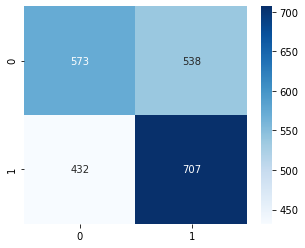

In [12]:
def gnb(X_train, y_train, X_test, y_test):
    start_timeGaussianNB = time.time()
    modelGNB = GaussianNB()
    modelGNB.fit(X_train, y_train)
    predictionsGNB = modelGNB.predict(X_test)
    accuracyGNB = metrics.accuracy_score(y_test, predictionsGNB)
    print("Accuracy (XGBoost): ", accuracyGNB)
    timeGNB = time.time() - start_timeGaussianNB
    print("Time taken to achive result: %s seconds" % (timeGNB))
    
    plt.figure(figsize=(5,4))
    print(classification_report(y_test, predictionsGNB))
    sns.heatmap(confusion_matrix(y_test, predictionsGNB), cmap = "Blues", annot=True, fmt = '.0f')
    return modelGNB, predictionsGNB, accuracyGNB, timeGNB

modelGNB, predictionsGNB, accuracyGNB, timeGNB = gnb(X_train, y_train, X_test, y_test)

### Random Forests Classifier

We can now move on to more advanced models that use Ensemble Learning (the concept is explained in detail in the "Airline Satisfaction" notebook). The first one of these shall be the <b>Random Forests</b> Classifier. This classifier uses ensemble learning by constructing a multitude of decision trees (specified with the n_estimators hyperparameter, defaults at 100), with a maximum depth of 10 for each tree (specified by the max_depth hyperparameter). After several tests, the number of estimators was set to 500, as the best correlation of accuracy to time and resource consumption.<br>
For the test set, each trees prediction is calculated, the results then aggregated, and the final answer is given. The aggregation is performed by each trees result counted and the "majority vote" is the final answer of the classifier.

In [18]:
#Random Forests
start_timeRandForests = time.time()
modelRandForests = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 0, max_depth = 10)
modelRandForests.fit(X_train_Reduced, y_train)
predictionsRandForests = modelRandForests.predict(X_test_Reduced)
accuracyRandForests = metrics.accuracy_score(y_test, predictionsRandForests)
print("Accuracy (Random Forests): ", accuracyRandForests)
timeRandForests = time.time() - start_timeRandForests
print("Time taken to achive result: %s seconds" % (timeRandForests))

Accuracy (Random Forests):  0.6355555555555555
Time taken to achive result: 11.774338722229004 seconds


              precision    recall  f1-score   support

           0       0.63      0.65      0.64      1111
           1       0.65      0.62      0.63      1139

    accuracy                           0.64      2250
   macro avg       0.64      0.64      0.64      2250
weighted avg       0.64      0.64      0.64      2250



<AxesSubplot:>

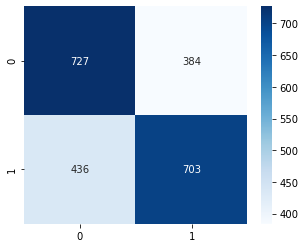

In [19]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsRandForests))
sns.heatmap(confusion_matrix(y_test, predictionsRandForests), cmap = "Blues", annot=True, fmt = '.0f')

### AdaBoost Classifier

Next, we will check the performance of the <b>AdaBoost Classifier</b> (AdaBoost stands for Adaptive Boost). This classifier also uses ensemble learning, as well as boosting, to achieve its purpose. After receiving the results from some base classifier, in our case the Decision Tree Classifier, the model then performs the base classifier over and over (n_estimator times), while each time giving more weight to the misclassified training instances. Then, again using ensemble learning techniques the model returns its final answer according to the many sub-models it created.<br>
The learning rate hyperparameter was left at the default value of 1 (after several tests to determine the best value). The hyperparameter specifies the rate of adaptability of the classifier to the data after each iteration of the estimator.

In [20]:
#AdaBoost
start_timeAdaBoost = time.time()
modelAdaBoost = AdaBoostClassifier(modelRandForests, n_estimators = 1000, random_state = 0, learning_rate = 1)
modelAdaBoost.fit(X_train_Reduced, y_train)
predictionsAdaBoost = modelAdaBoost.predict(X_test_Reduced)
accuracyAdaBoost = metrics.accuracy_score(y_test, predictionsAdaBoost)
print("Accuracy (AdaBoost): ", accuracyAdaBoost)
timeAdaBoost = time.time() - start_timeAdaBoost
print("Time taken to achive result: %s seconds" % (timeAdaBoost))

Accuracy (AdaBoost):  0.6471111111111111
Time taken to achive result: 106.05802512168884 seconds


              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1111
           1       0.65      0.65      0.65      1139

    accuracy                           0.65      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.65      0.65      0.65      2250



<AxesSubplot:>

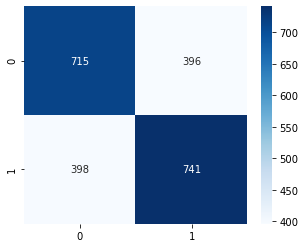

In [21]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsAdaBoost))
sns.heatmap(confusion_matrix(y_test, predictionsAdaBoost), cmap = "Blues", annot=True, fmt = '.0f')

### XGBoost Classifier

Last of the single models (but certainly not least), we shall run the <b>XGBoost Classifier</b> on our data (XGBoost standing for Extreme Gradient Boosting, which uses Ensemble Learning and boosting in a similar yet different way to AdaBoost above. Where AdaBoost tweaks the individual instance weights, giving some more or less weight, XGBoost fits a new predictor to the residual errors made by the previous predictor. It should be noted that the residual errors get smaller with each iteration of XGBoost, making the model very effective (in many cases the most effective out of all).

In [22]:
#XGBoost
start_timeXGBoost = time.time()
modelXGBoost = XGBClassifier(learning_rate = 0.1,
                             n_estimators = 3000,
                             verbosity = 0,
                             use_label_encoder = False,
                             max_depth = 6,
                             n_jobs = -1)
modelXGBoost.fit(X_train_Reduced, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test_Reduced)
accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achive result: %s seconds" % (timeXGBoost))

Accuracy (XGBoost):  0.6626666666666666
Time taken to achive result: 447.85685992240906 seconds


              precision    recall  f1-score   support

           0       0.66      0.66      0.66      1111
           1       0.67      0.67      0.67      1139

    accuracy                           0.66      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.66      0.66      0.66      2250



<AxesSubplot:>

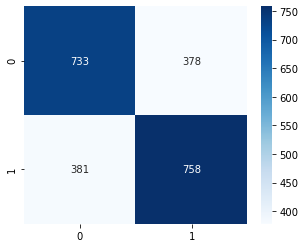

In [23]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsXGBoost))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')

### Voting Classifier

Now that all models are trained, and they are not bad at all, we can try to combine them and get "the best out of all worlds". This we shall first try by using the <b>Voting Classifier</b>. This classifier takes the results of each model (given in the "estimators" hyperparameter), and compares the results given by each model for every record of the dataframe, returning the value that most classifiers agree on. The voting method was changed to "soft", meaning that from each classifier, the probability of each result will be considered ("how sure the classifier is that its final decision is correct"), rather than the raw "yes or no" in the case of "hard" voting method. The weights of each model in the evaluation are also given, for we know that the last 3 classifiers had much better results than the first two.

In [24]:
#Voting
start_timeVoting = time.time()
modelVoting = VotingClassifier(
    estimators=
        [('KNN', modelKNN),
         ('LogReg', modelLogReg),
         ('RandForests', modelRandForests),
         ('AdaBoost', modelAdaBoost),
         ('XGBoost', modelXGBoost)],
    voting='soft', n_jobs=-1, weights=[1, 1, 3, 3, 3])
modelVoting.fit(X_train_Reduced, y_train)
predictionsVoting = modelVoting.predict(X_test_Reduced)
accuracyVoting = metrics.accuracy_score(y_test, predictionsVoting)
print("Accuracy: ", accuracyVoting)
timeVoting = time.time() - start_timeVoting
print("Time taken to achive result: %s seconds" % (timeVoting))

Accuracy:  0.6653333333333333
Time taken to achive result: 566.3723590373993 seconds


              precision    recall  f1-score   support

           0       0.66      0.67      0.66      1111
           1       0.67      0.66      0.67      1139

    accuracy                           0.67      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.67      0.67      0.67      2250



<AxesSubplot:>

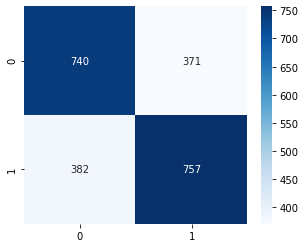

In [25]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsVoting))
sns.heatmap(confusion_matrix(y_test, predictionsVoting), cmap = "Blues", annot=True, fmt = '.0f')

### Bagging and Pasting Classifiers

Another option we will now observe is to use the <b>Bagging/Pasting Classifiers</b>. These classifiers combine not many different models, but a single model where the data is divided into multiple parts (the number is defined in the n_estimators hyperparameter), and a single model is run on all these subsections, resulting in a quite accurate model. When the samples taken from the complete dataset can be chosen twice or more for a single predictor, the model is called Bagging, if not then it is Pasting. In practice, Pasting is used more when the dataset is large, while for smaller datasets, the Bagging Classifier may be a good choice. We will try to use both classifiers to see how it performs on our data. The difference between the two classifiers in code is only the "bootstrap" hyperparameter. We will Use the XGBoost classifier as the estimator, as it performed best out of the classifiers we have evaluated up to this point, but we shall reduce the number of estimators in each XGBoost run to reduce runtime.

#### Bagging Classifier

In [26]:
#Bagging
modelXGBoostNew = XGBClassifier(learning_rate = 0.1,
                             n_estimators = 500,
                             verbosity = 0,
                             use_label_encoder = False,
                             max_depth = 6,
                             n_jobs = -1)
start_timeBagging = time.time()
warnings.filterwarnings('ignore')
modelBagging = BaggingClassifier(modelXGBoostNew, n_estimators = 100, bootstrap = True)
modelBagging.fit(X_train_Reduced, y_train)
predictionsBagging = modelBagging.predict(X_test_Reduced)
accuracyBagging = metrics.accuracy_score(y_test, predictionsBagging)
print("Accuracy: ", accuracyBagging)
timeBagging = time.time() - start_timeBagging
print("Time taken to achive result: %s seconds" % (timeBagging))

Accuracy:  0.6608888888888889
Time taken to achive result: 8252.281884670258 seconds


              precision    recall  f1-score   support

           0       0.65      0.68      0.66      1111
           1       0.67      0.65      0.66      1139

    accuracy                           0.66      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.66      0.66      0.66      2250



<AxesSubplot:>

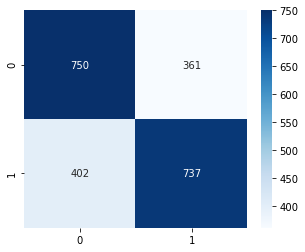

In [27]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsBagging))
sns.heatmap(confusion_matrix(y_test, predictionsBagging), cmap = "Blues", annot=True, fmt = '.0f')

#### Pasting Classifier

In [28]:
#Pasting
start_timePasting = time.time()
warnings.filterwarnings('ignore')
modelPasting = BaggingClassifier(modelXGBoostNew, n_estimators = 100, bootstrap = False)
modelPasting.fit(X_train_Reduced, y_train)
predictionsPasting = modelPasting.predict(X_test_Reduced)
accuracyPasting = metrics.accuracy_score(y_test, predictionsPasting)
print("Accuracy: ", accuracyPasting)
timePasting = time.time() - start_timePasting
print("Time taken to achive result: %s seconds" % (timePasting))

Accuracy:  0.6466666666666666
Time taken to achive result: 8466.493944883347 seconds


              precision    recall  f1-score   support

           0       0.64      0.64      0.64      1111
           1       0.65      0.65      0.65      1139

    accuracy                           0.65      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.65      0.65      0.65      2250



<AxesSubplot:>

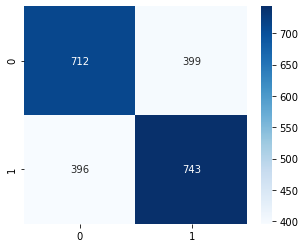

In [29]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsPasting))
sns.heatmap(confusion_matrix(y_test, predictionsPasting), cmap = "Blues", annot=True, fmt = '.0f')

### Stacking Classifier

The last ensemble method we will evaluate is the <b>Stacking Classifier</b>. This uses the simple yet elegant idea to take the results given by each predictor for each method, and unlike the voting classifier, build a new model to evaluate them and return an answer, which shall be the final result for the instance for this classifier.

In [30]:
#Stacking
start_timeStacking = time.time()
warnings.filterwarnings('ignore')
modelStacking = StackingClassifier(estimators= [('KNN', modelKNN),
                                      ('LogReg', modelLogReg),
                                      ('RandForests', modelRandForests),
                                      ('AdaBoost', modelAdaBoost),
                                      ('XGBoost', modelXGBoost)], 
                         final_estimator = modelXGBoost)
modelStacking.fit(X_train_Reduced, y_train)
predictionsStacking = modelStacking.predict(X_test_Reduced)
accuracyStacking = metrics.accuracy_score(y_test, predictionsStacking)
print("Accuracy: ", accuracyStacking)
timeStacking = time.time() - start_timeStacking
print("Time taken to achive result: %s seconds" % (timeStacking))

Accuracy:  0.6271111111111111
Time taken to achive result: 3340.3412919044495 seconds


              precision    recall  f1-score   support

           0       0.62      0.63      0.62      1111
           1       0.63      0.63      0.63      1139

    accuracy                           0.63      2250
   macro avg       0.63      0.63      0.63      2250
weighted avg       0.63      0.63      0.63      2250



<AxesSubplot:>

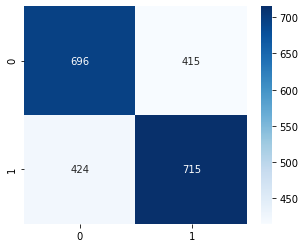

In [31]:
plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsStacking))
sns.heatmap(confusion_matrix(y_test, predictionsStacking), cmap = "Blues", annot=True, fmt = '.0f')

## Classifier Evaluation

Below is the ROC Curve for the classifiers that we have tried (ROC curve explained in full in the "Airline Satisfaction" notebook), but as we can see, this graph does not tell us much, as most of the models overlap and their accuracy is very close to one another. The ROC Curve's "only concern" is the accuracy of the classifier, but we wish to evaluate the best classifier in terms of effectiveness (accuracy vs. runtime), so the ROC Curve is of limited use.

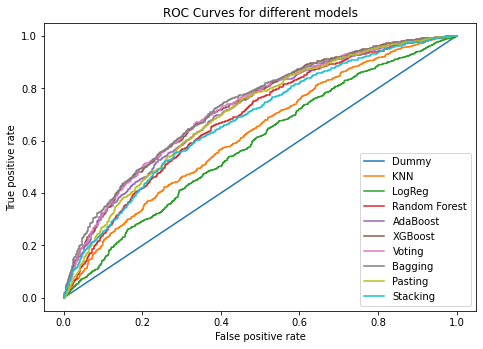

In [32]:
probsKNN = modelKNN.predict_proba(X_test_Reduced)[:, 1]
probsLogReg = modelLogReg.predict_proba(X_test_Reduced)[:, 1]
dummyProbs = dummyModel.predict_proba(X_test_Reduced)[:, 1]
probsRandomForests = modelRandForests.predict_proba(X_test_Reduced)[:, 1]
probsAdaBoost = modelAdaBoost.predict_proba(X_test_Reduced)[:, 1]
probsXGBoost = modelXGBoost.predict_proba(X_test_Reduced)[:, 1]
probsVoting = modelVoting.predict_proba(X_test_Reduced)[:, 1]
probsBagging = modelBagging.predict_proba(X_test_Reduced)[:, 1]
probsPasting = modelPasting.predict_proba(X_test_Reduced)[:, 1]
probsStacking = modelStacking.predict_proba(X_test_Reduced)[:, 1]

fprLogReg, tprLogReg, thresholdsLogReg = metrics.roc_curve(y_test, probsLogReg)
fprKNN, tprKNN, thresholdsKNN = metrics.roc_curve(y_test, probsKNN)
fprDummy, tprDummy, thresholdsDummy = metrics.roc_curve(y_test, dummyProbs)
fprRandFor, tprRandFor, thresholdsRandFor = metrics.roc_curve(y_test, probsRandomForests)
fprAdaB, tprAdaB, thresholdsAdaB = metrics.roc_curve(y_test, probsAdaBoost)
fprXGB, tprXGB, thresholdsXGB = metrics.roc_curve(y_test, probsXGBoost)
fprVot, tprVot, thresholdsVot = metrics.roc_curve(y_test, probsVoting)
fprBag, tprBag, thresholdsBag = metrics.roc_curve(y_test, probsBagging)
fprPas, tprPas, thresholdsPas = metrics.roc_curve(y_test, probsPasting)
fprSta, tprSta, thresholdsSta = metrics.roc_curve(y_test, probsStacking)

fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(fprDummy, tprDummy, label = "Dummy")
axes.plot(fprKNN, tprKNN, label = "KNN")
axes.plot(fprLogReg, tprLogReg, label = "LogReg")
axes.plot(fprRandFor, tprRandFor, label = "Random Forest")
axes.plot(fprAdaB, tprAdaB, label = "AdaBoost")
axes.plot(fprXGB, tprXGB, label = "XGBoost")
axes.plot(fprVot, tprVot, label = "Voting")
axes.plot(fprBag, tprBag, label = "Bagging")
axes.plot(fprPas, tprPas, label = "Pasting")
axes.plot(fprSta, tprSta, label = "Stacking")

axes.set_xlabel("False positive rate")
axes.set_ylabel("True positive rate")
axes.set_title("ROC Curves for different models")
axes.legend()

We will plot a bar graph to help us see the accuracies better and limiting the y axis so that the differences are more pronounced. Here, the accuracies can be judged much better than any other method, with the Voting Classifier being the best, with XGBoost and Bagging Classifiers close behind. The Dummy classifier has, as expected , performed worse than all our other classifiers, meaning all models have some functionality and are not a total waste.

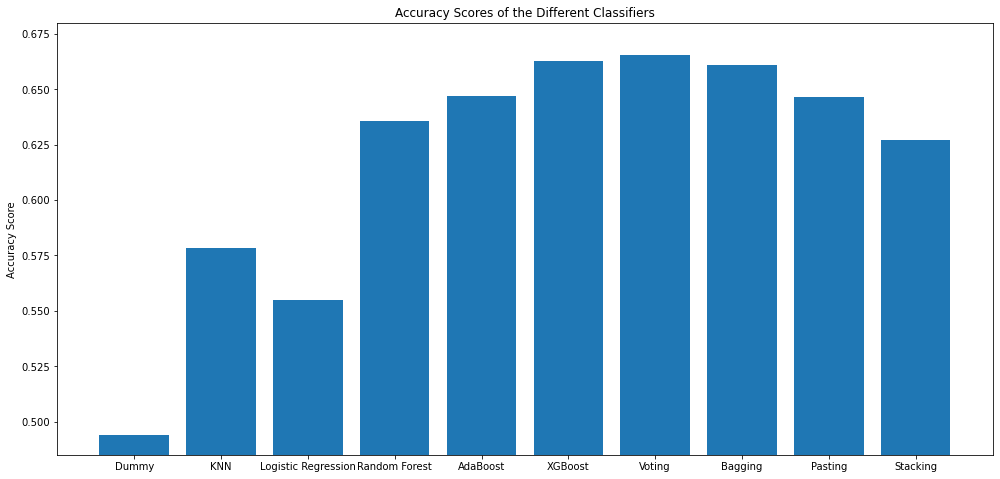

In [33]:
def accuraciesGraph(bounds):
    accuracies = [accuracyDummy, accuracyKNN, accuracyLogReg, accuracyRandForests, accuracyAdaBoost, accuracyXGBoost,
                  accuracyVoting, accuracyBagging, accuracyPasting, accuracyStacking]
    fig = plt.figure(figsize=(13,6))
    accuraciesSize = np.arange(len(accuracies))
    axes = fig.add_axes([0,0,1,1])
    labels = ['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
              'Pasting', 'Stacking']
    axes.bar(labels, accuracies)
    axes.set_ylabel("Accuracy Score")
    axes.set_title("Accuracy Scores of the Different Classifiers")
    plt.rcParams['xtick.labelsize'] = 10
    axes.set_ylim(bounds)
    
accuraciesGraph([0.485, 0.68])

Next, the bar graph for the runtimes is shown. We can identify the Bagging Classifier as the one with the longest runtime, while The Dummy, KNN, Logistic Regression and Random Forests classifiers had the best runtime.

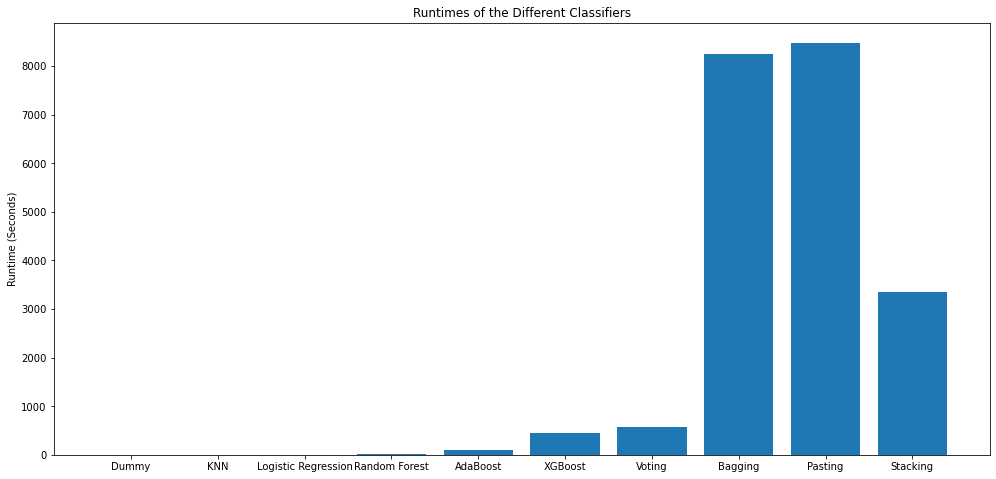

In [34]:
def timeGraph():
    fig = plt.figure(figsize=(13,6))

    time = [timeDummy, timeKNN, timeLogReg, timeRandForests, timeAdaBoost, timeXGBoost,
             timeVoting, timeBagging, timePasting, timeStacking]
    timeSize = np.arange(len(time))
    axes = fig.add_axes([0,0,1,1])
    labels = ['Dummy', 'KNN', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'XGBoost', 'Voting', 'Bagging',
              'Pasting', 'Stacking']
    axes.bar(labels, time)
    axes.set_ylabel("Runtime (Seconds)")
    axes.set_title("Runtimes of the Different Classifiers")
    plt.rcParams['xtick.labelsize'] = 10
    
timeGraph()

Finally, we will create a table (a dataframe), that will show us the considered data, to help us define the best classifier out of all. Although the table is very helpful, it is still quite hard to see the differences between the accuracies of the classifiers (though quite easy to see the differences of runtime). We may then sort the dataframe in descending order of accuracies, to boost the understandability of the table.

In [35]:
results = pd.DataFrame(np.array([['Dummy (B&W)', accuracyDummy, timeDummy],
                            ['KNN (B&W)', accuracyKNN, timeKNN],
                            ['Logistic Regression (B&W)', accuracyLogReg, timeLogReg],
                            ['Random Forests (B&W)', accuracyRandForests, timeRandForests],
                            ['AdaBoost (B&W)', accuracyAdaBoost, timeAdaBoost],
                            ['XGBoost (B&W)', accuracyXGBoost, timeXGBoost],
                            ['Voting (B&W)', accuracyVoting, timeVoting],
                            ['Bagging (B&W)', accuracyBagging, timeBagging],
                            ['Pasting (B&W)', accuracyPasting, timePasting],
                            ['Stacking (B&W)', accuracyStacking, timeStacking]]),
                  columns=['Model', 'Accuracy', 'Runtime (Seconds)'])

resultsView = results.sort_values(by = 'Accuracy', axis = 0, ascending = False)
resultsView = resultsView.style.set_properties(**{'text-align': 'left'})
resultsView

,Model,Accuracy,Runtime (Seconds)
6,Voting (B&W),0.6653333333333333,566.3723590373993
5,XGBoost (B&W),0.6626666666666666,447.85685992240906
7,Bagging (B&W),0.6608888888888889,8252.281884670258
4,AdaBoost (B&W),0.6471111111111111,106.05802512168884
8,Pasting (B&W),0.6466666666666666,8466.493944883347
3,Random Forests (B&W),0.6355555555555555,11.774338722229004
9,Stacking (B&W),0.6271111111111111,3340.3412919044495
1,KNN (B&W),0.5782222222222222,0.7063870429992676
2,Logistic Regression (B&W),0.5546666666666666,0.6389014720916748
0,Dummy (B&W),0.49377777777777776,0.34319186210632324


In [ ]:
results.to_csv('Data/Cats vs Dogs/results.csv')

In [78]:
results = pd.read_csv('Data/Cats vs Dogs/results.csv')
results = df.drop(['Unnamed: 0'], axis = 1)

results['Accuracy'] = pd.to_numeric(results['Accuracy'])
results['Runtime (Seconds)'] = pd.to_numeric(results['Runtime (Seconds)'])

## Mid-Way Conclusion

Up to this point, we have examined the dataset presented as a black and white dataset with the hypothesis that the colour does not affect much (if at all) the images. This assumption, while may be justified from the perspective of a human being, does not in any way suggest it is the case for a machine. This will momentarily be remedied.

Despite this, we might still make some conclusions based on the classifiers we have examined.<br>
We will consider the three most accurate models first (the difference in accuracies between them is quite minor: from 0.1% to 0.2%: The most accurate model was the Voting Classifier, with the runtime of almost 21 minutes (1259 seconds). The second most accurate model was the Bagging Classifier, but its runtime was almost 7 times the runtime of the Voting Classifier (more than 2 hours), for which reason we will not even consider it in our final decision. The third most accurate model is the XGBoost Classifier, which took 7 and a half (roughly) minutes to run.<br>
Moreover, I believe we must also consider the Random Forests classifier in our judgement, due to its spectacular runtime (only 11 seconds), though the loss of accuracy is roughly 3% from the accuracies of the XGBoost and Voting Classifiers.

In my personal opinion, the XGBoost’s "accuracy versus runtime" score overpowers the one of Voting and Random Forests Classifiers, meaning that I will consider it better, although it is not necessarily the case, depending on the desired results and the available resources.

## Images in Colour

Now that we have evaluated the images in grayscale, we can try to implement the same techniques on images in color and try to see if the images in colour provide us with a better accuracy than the ones in grayscale. The process of data loading and preprocessing has to be accomplished again, too, due to the assumption of working on grayscale being at the very beginning of the notebook. As the code is almost identical (the difference is in data loading, the function saves the image in colour rather than grayscale, and the ravel() function flattens a 3D array rather than a 2D array into a 1D array), no explanations regarding the code will be given. We will resize the color images to 50X50, and thus the total number of features will be 7500 (50X50X3), which is not too far from the 10000 of the grayscale images.

##### Preprocessing:

In [35]:
list = []
for i in range(50*50*3):
    list.append(i)
dfDogs = pd.DataFrame(columns=list)
dfCats = pd.DataFrame(columns=list)

dfDogs = toDF(dfDogs, 'dog', cv2.IMREAD_COLOR, 50, 50)
dfCats = toDF(dfCats, 'cat', cv2.IMREAD_COLOR, 50, 50)

df = mergeDF(dfDogs, dfCats)

df.to_csv('Data/Cats vs Dogs/dfColour.csv')
df = pd.read_csv('Data/Cats vs Dogs/dfColour.csv')
df = df.drop(['Unnamed: 0'], axis = 1)

print("There are", df.isna().sum().sum(), "NaN value")

x = df.drop(['Dog/Cat'], axis = 1)
y = df['Dog/Cat']

X_train_Total, X_test_Final, y_train_Total, y_test_Final = train_test_split(x, y, test_size = 0.1, random_state = 0)

X_train, X_test, y_train, y_test = train_test_split(X_train_Total, y_train_Total,
                                                                test_size = 0.1, random_state = 0)

X_train, y_train = removeDuplicates(X_train, y_train)

X_train, X_test, X_test_Final = scale(X_train, X_test, X_test_Final)

X_train_Reduced, X_test_Reduced, X_test_Final_Reduced = PCAFunc(X_train, X_test, X_test_Final)

print(X_train_Reduced.shape)

There are 0 NaN value
(20246, 381)


##### Classifiers:

Accuracy (KNN):  0.49377777777777776
Time taken to achive result: 0.5017495155334473 seconds


              precision    recall  f1-score   support

           0       0.49      1.00      0.66      1111
           1       0.00      0.00      0.00      1139

    accuracy                           0.49      2250
   macro avg       0.25      0.50      0.33      2250
weighted avg       0.24      0.49      0.33      2250



<AxesSubplot:>

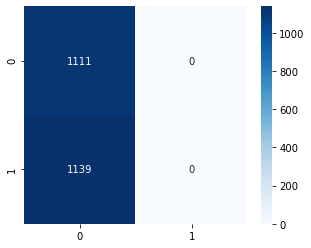

In [36]:
#Dummy
start_timeDummy = time.time()
dummyModel = DummyClassifier(strategy="most_frequent")
dummyModel.fit(X_train_Reduced, y_train)
predictionsDummy = dummyModel.predict(X_test_Reduced)

accuracyDummy = metrics.accuracy_score(y_test, predictionsDummy)
print("Accuracy (KNN): ", accuracyDummy)
timeDummy = time.time() - start_timeDummy
print("Time taken to achive result: %s seconds\n\n" % (timeDummy))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsDummy, zero_division = 0))
sns.heatmap(confusion_matrix(y_test, predictionsDummy), cmap = "Blues", annot=True, fmt = '.0f')

Accuracy (KNN):  0.5995555555555555
Time taken to achive result: 0.8187406063079834 seconds


              precision    recall  f1-score   support

           0       0.59      0.60      0.60      1111
           1       0.61      0.60      0.60      1139

    accuracy                           0.60      2250
   macro avg       0.60      0.60      0.60      2250
weighted avg       0.60      0.60      0.60      2250



<AxesSubplot:>

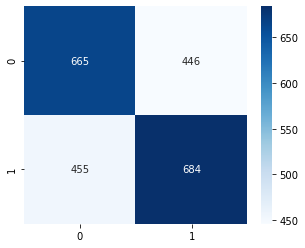

In [37]:
#KNN
start_timeKNN = time.time()
modelKNN = KNeighborsClassifier(n_neighbors = 15, weights='distance')
modelKNN.fit(X_train_Reduced, y_train)
predictionsKNN = modelKNN.predict(X_test_Reduced)
accuracyKNN = metrics.accuracy_score(y_test, predictionsKNN)
print("Accuracy (KNN): ", accuracyKNN)
timeKNN = time.time() - start_timeKNN
print("Time taken to achive result: %s seconds\n\n" % (timeKNN))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsKNN))
sns.heatmap(confusion_matrix(y_test, predictionsKNN), cmap = "Blues", annot=True, fmt = '.0f')

Accuracy (KNN):  0.5995555555555555
Time taken to achive result: 0.9184842109680176 seconds


              precision    recall  f1-score   support

           0       0.61      0.65      0.63      1111
           1       0.63      0.60      0.62      1139

    accuracy                           0.62      2250
   macro avg       0.62      0.62      0.62      2250
weighted avg       0.62      0.62      0.62      2250



<AxesSubplot:>

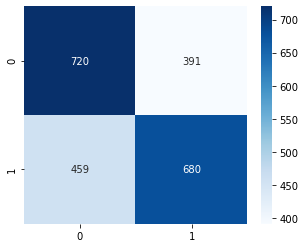

In [38]:
#Logistic Regression
start_timeLogReg = time.time()
modelLogReg = LogisticRegression()
modelLogReg.fit(X_train_Reduced, y_train)
predictionsLogReg = modelLogReg.predict(X_test_Reduced)
accuracyLogReg = modelLogReg.score(X_test_Reduced, y_test)
print("Accuracy (KNN): ", accuracyKNN)
timeLogReg = time.time() - start_timeLogReg
print("Time taken to achive result: %s seconds\n\n" % (timeLogReg))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsLogReg))
sns.heatmap(confusion_matrix(y_test, predictionsLogReg), cmap = "Blues", annot=True, fmt = '.0f')

Accuracy (XGBoost):  0.5666666666666667
Time taken to achive result: 4.690191984176636 seconds
              precision    recall  f1-score   support

           0       0.57      0.52      0.54      1111
           1       0.57      0.61      0.59      1139

    accuracy                           0.57      2250
   macro avg       0.57      0.57      0.57      2250
weighted avg       0.57      0.57      0.57      2250



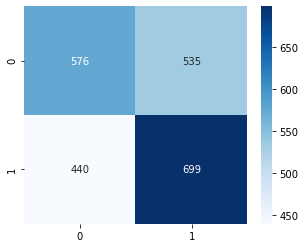

In [14]:
modelGNB, predictionsGNB, accuracyGNB, timeGNB = gnb(X_train, y_train, X_test, y_test)

Accuracy (Random Forests):  0.6444444444444445
Time taken to achive result: 12.584174633026123 seconds


              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1111
           1       0.67      0.58      0.62      1139

    accuracy                           0.64      2250
   macro avg       0.65      0.65      0.64      2250
weighted avg       0.65      0.64      0.64      2250



<AxesSubplot:>

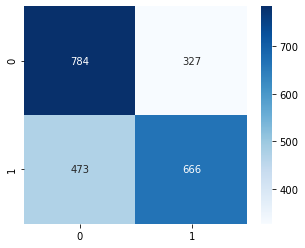

In [39]:
#Random Forests
start_timeRandForests = time.time()
modelRandForests = RandomForestClassifier(n_estimators = 500, n_jobs = -1, random_state = 0, max_depth = 10)
modelRandForests.fit(X_train_Reduced, y_train)
predictionsRandForests = modelRandForests.predict(X_test_Reduced)
accuracyRandForests = metrics.accuracy_score(y_test, predictionsRandForests)
print("Accuracy (Random Forests): ", accuracyRandForests)
timeRandForests = time.time() - start_timeRandForests
print("Time taken to achive result: %s seconds\n\n" % (timeRandForests))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsRandForests))
sns.heatmap(confusion_matrix(y_test, predictionsRandForests), cmap = "Blues", annot=True, fmt = '.0f')

Accuracy (AdaBoost):  0.6377777777777778
Time taken to achive result: 1265.7562367916107 seconds


              precision    recall  f1-score   support

           0       0.62      0.67      0.65      1111
           1       0.65      0.60      0.63      1139

    accuracy                           0.64      2250
   macro avg       0.64      0.64      0.64      2250
weighted avg       0.64      0.64      0.64      2250



<AxesSubplot:>

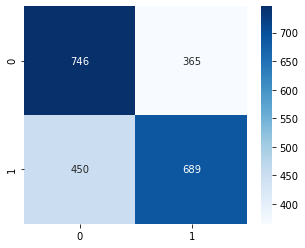

In [40]:
#AdaBoost
start_timeAdaBoost = time.time()
modelDecTree = DecisionTreeClassifier(random_state=0, max_depth=2)
modelAdaBoost = AdaBoostClassifier(modelDecTree, n_estimators = 1000, random_state = 0, learning_rate = 1)
modelAdaBoost.fit(X_train_Reduced, y_train)
predictionsAdaBoost = modelAdaBoost.predict(X_test_Reduced)
accuracyAdaBoost = metrics.accuracy_score(y_test, predictionsAdaBoost)
print("Accuracy (AdaBoost): ", accuracyAdaBoost)
timeAdaBoost = time.time() - start_timeAdaBoost
print("Time taken to achive result: %s seconds\n\n" % (timeAdaBoost))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsAdaBoost))
sns.heatmap(confusion_matrix(y_test, predictionsAdaBoost), cmap = "Blues", annot=True, fmt = '.0f')

Below is the XGBoost Classifier. Upon several runs, we can surmise that with the increase of the n_estimators hyperparameter (up to 6000 was checked), the accuracy of the model increases. For example, if the n_estimators was set to 6000, the accuracy increases to 0.6977, but so does the runtime. This is an increase of roughly 0.1% from the accuracy presented below, but the increase in runtime is much bigger. In my opinion, "the ends do not justify the means", meaning that the accuracy vs runtime is better with the hyperparameters set to the ones presented below, hence we will continue with this model as the best out of XGBoost.

Accuracy (XGBoost):  0.6964444444444444
Time taken to achive result: 573.0118672847748 seconds


              precision    recall  f1-score   support

           0       0.68      0.72      0.70      1111
           1       0.71      0.67      0.69      1139

    accuracy                           0.70      2250
   macro avg       0.70      0.70      0.70      2250
weighted avg       0.70      0.70      0.70      2250



<AxesSubplot:>

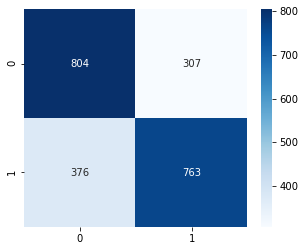

In [24]:
#XGBoost
start_timeXGBoost = time.time()
modelXGBoost = XGBClassifier(learning_rate = 0.1,
                             n_estimators = 3000,
                             verbosity = 0,
                             use_label_encoder = False,
                             max_depth = 6,
                             n_jobs = -1)
modelXGBoost.fit(X_train_Reduced, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test_Reduced)
accuracyXGBoost = metrics.accuracy_score(y_test, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achive result: %s seconds\n\n" % (timeXGBoost))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsXGBoost))
sns.heatmap(confusion_matrix(y_test, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')

Accuracy:  0.6995555555555556
Time taken to achive result: 1359.0960643291473 seconds


              precision    recall  f1-score   support

           0       0.68      0.73      0.71      1111
           1       0.72      0.67      0.69      1139

    accuracy                           0.70      2250
   macro avg       0.70      0.70      0.70      2250
weighted avg       0.70      0.70      0.70      2250



<AxesSubplot:>

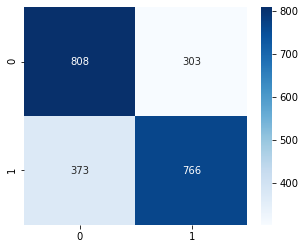

In [42]:
#Voting
start_timeVoting = time.time()
modelVoting = VotingClassifier(
    estimators=
        [('KNN', modelKNN),
         ('LogReg', modelLogReg),
         ('RandForests', modelRandForests),
         ('AdaBoost', modelAdaBoost),
         ('XGBoost', modelXGBoost)],
    voting='soft', n_jobs=-1, weights=[1, 1, 3, 3, 3])
modelVoting.fit(X_train_Reduced, y_train)
predictionsVoting = modelVoting.predict(X_test_Reduced)
accuracyVoting = metrics.accuracy_score(y_test, predictionsVoting)
print("Accuracy: ", accuracyVoting)
timeVoting = time.time() - start_timeVoting
print("Time taken to achive result: %s seconds\n\n" % (timeVoting))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsVoting))
sns.heatmap(confusion_matrix(y_test, predictionsVoting), cmap = "Blues", annot=True, fmt = '.0f')

Accuracy:  0.6813333333333333
Time taken to achive result: 3705.8694591522217 seconds


              precision    recall  f1-score   support

           0       0.66      0.72      0.69      1111
           1       0.70      0.64      0.67      1139

    accuracy                           0.68      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.68      0.68      0.68      2250



<AxesSubplot:>

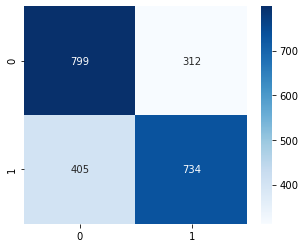

In [49]:
#Bagging
modelXGBoostNew = XGBClassifier(learning_rate = 0.1,
                             n_estimators = 200,
                             verbosity = 0,
                             use_label_encoder = False,
                             max_depth = 6,
                             n_jobs = -1)
start_timeBagging = time.time()
warnings.filterwarnings('ignore')
modelBagging = BaggingClassifier(modelXGBoostNew, n_estimators = 100, bootstrap = True)
modelBagging.fit(X_train_Reduced, y_train)
predictionsBagging = modelBagging.predict(X_test_Reduced)
accuracyBagging = metrics.accuracy_score(y_test, predictionsBagging)
print("Accuracy: ", accuracyBagging)
timeBagging = time.time() - start_timeBagging
print("Time taken to achive result: %s seconds\n\n" % (timeBagging))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsBagging))
sns.heatmap(confusion_matrix(y_test, predictionsBagging), cmap = "Blues", annot=True, fmt = '.0f')

Accuracy:  0.6697777777777778
Time taken to achive result: 3777.3916277885437 seconds


              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1111
           1       0.69      0.64      0.66      1139

    accuracy                           0.67      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.67      0.67      0.67      2250



<AxesSubplot:>

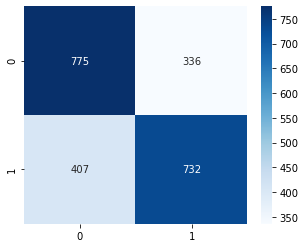

In [51]:
#Pasting
start_timePasting = time.time()
warnings.filterwarnings('ignore')
modelPasting = BaggingClassifier(modelXGBoostNew, n_estimators = 100, bootstrap = False)
modelPasting.fit(X_train_Reduced, y_train)
predictionsPasting = modelPasting.predict(X_test_Reduced)
accuracyPasting = metrics.accuracy_score(y_test, predictionsPasting)
print("Accuracy: ", accuracyPasting)
timePasting = time.time() - start_timePasting
print("Time taken to achive result: %s seconds\n\n" % (timePasting))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsPasting))
sns.heatmap(confusion_matrix(y_test, predictionsPasting), cmap = "Blues", annot=True, fmt = '.0f')

Accuracy:  0.6568888888888889
Time taken to achive result: 8878.891644477844 seconds


              precision    recall  f1-score   support

           0       0.64      0.68      0.66      1111
           1       0.67      0.63      0.65      1139

    accuracy                           0.66      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.66      0.66      0.66      2250



<AxesSubplot:>

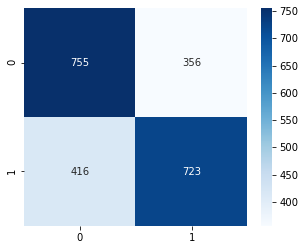

In [52]:
#Stacking
start_timeStacking = time.time()
warnings.filterwarnings('ignore')
modelStacking = StackingClassifier(estimators= [('KNN', modelKNN),
                                      ('LogReg', modelLogReg),
                                      ('RandForests', modelRandForests),
                                      ('AdaBoost', modelAdaBoost),
                                      ('XGBoost', modelXGBoost)], 
                         final_estimator = modelXGBoost)
modelStacking.fit(X_train_Reduced, y_train)
predictionsStacking = modelStacking.predict(X_test_Reduced)
accuracyStacking = metrics.accuracy_score(y_test, predictionsStacking)
print("Accuracy: ", accuracyStacking)
timeStacking = time.time() - start_timeStacking
print("Time taken to achive result: %s seconds\n\n" % (timeStacking))

plt.figure(figsize=(5,4))
print(classification_report(y_test, predictionsStacking))
sns.heatmap(confusion_matrix(y_test, predictionsStacking), cmap = "Blues", annot=True, fmt = '.0f')

We shall again plot the ROC Curves for the coloured images, as well as the 2 bar graphs presented above:

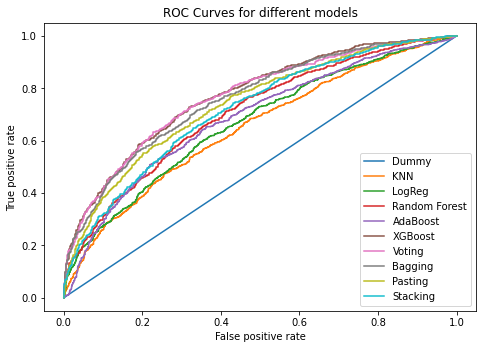

In [53]:
probsKNN = modelKNN.predict_proba(X_test_Reduced)[:, 1]
probsLogReg = modelLogReg.predict_proba(X_test_Reduced)[:, 1]
dummyProbs = dummyModel.predict_proba(X_test_Reduced)[:, 1]
probsRandomForests = modelRandForests.predict_proba(X_test_Reduced)[:, 1]
probsAdaBoost = modelAdaBoost.predict_proba(X_test_Reduced)[:, 1]
probsXGBoost = modelXGBoost.predict_proba(X_test_Reduced)[:, 1]
probsVoting = modelVoting.predict_proba(X_test_Reduced)[:, 1]
probsBagging = modelBagging.predict_proba(X_test_Reduced)[:, 1]
probsPasting = modelPasting.predict_proba(X_test_Reduced)[:, 1]
probsStacking = modelStacking.predict_proba(X_test_Reduced)[:, 1]

fprLogReg, tprLogReg, thresholdsLogReg = metrics.roc_curve(y_test, probsLogReg)
fprKNN, tprKNN, thresholdsKNN = metrics.roc_curve(y_test, probsKNN)
fprDummy, tprDummy, thresholdsDummy = metrics.roc_curve(y_test, dummyProbs)
fprRandFor, tprRandFor, thresholdsRandFor = metrics.roc_curve(y_test, probsRandomForests)
fprAdaB, tprAdaB, thresholdsAdaB = metrics.roc_curve(y_test, probsAdaBoost)
fprXGB, tprXGB, thresholdsXGB = metrics.roc_curve(y_test, probsXGBoost)
fprVot, tprVot, thresholdsVot = metrics.roc_curve(y_test, probsVoting)
fprBag, tprBag, thresholdsBag = metrics.roc_curve(y_test, probsBagging)
fprPas, tprPas, thresholdsPas = metrics.roc_curve(y_test, probsPasting)
fprSta, tprSta, thresholdsSta = metrics.roc_curve(y_test, probsStacking)

fig = plt.figure()
axes = fig.add_axes([0,0,1,1])
axes.plot(fprDummy, tprDummy, label = "Dummy")
axes.plot(fprKNN, tprKNN, label = "KNN")
axes.plot(fprLogReg, tprLogReg, label = "LogReg")
axes.plot(fprRandFor, tprRandFor, label = "Random Forest")
axes.plot(fprAdaB, tprAdaB, label = "AdaBoost")
axes.plot(fprXGB, tprXGB, label = "XGBoost")
axes.plot(fprVot, tprVot, label = "Voting")
axes.plot(fprBag, tprBag, label = "Bagging")
axes.plot(fprPas, tprPas, label = "Pasting")
axes.plot(fprSta, tprSta, label = "Stacking")

axes.set_xlabel("False positive rate")
axes.set_ylabel("True positive rate")
axes.set_title("ROC Curves for different models")
axes.legend()

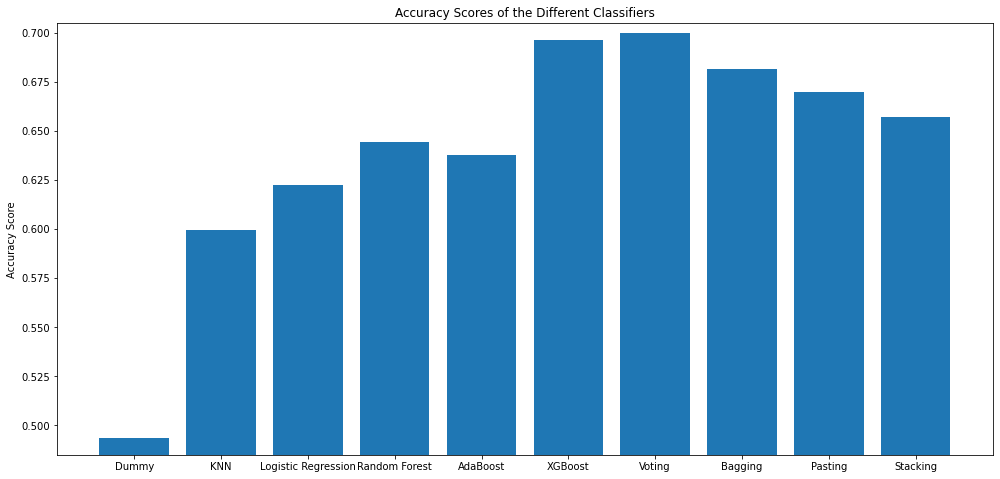

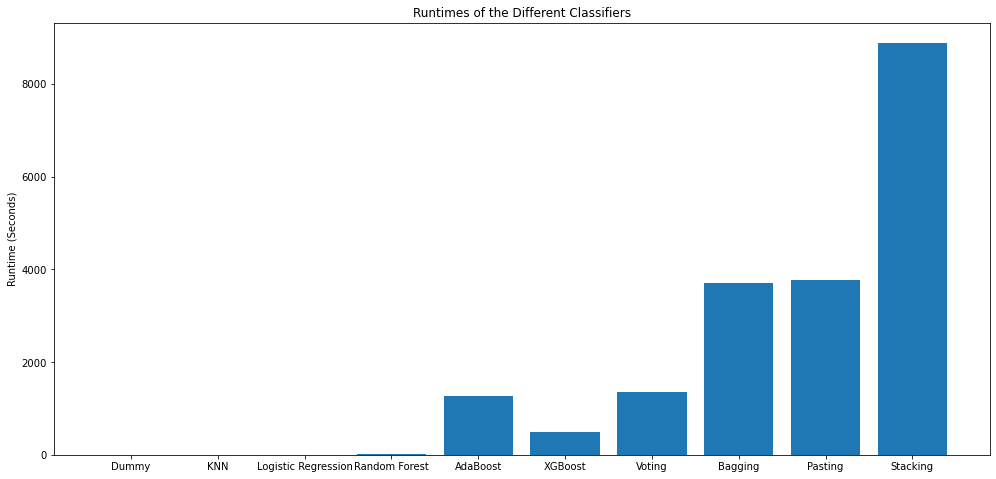

In [57]:
accuraciesGraph([0.485, 0.705])
timeGraph()

In [104]:
results = pd.read_csv('Data/Cats vs Dogs/results.csv')
results = results.drop(['Unnamed: 0'], axis = 1)

results

,Model,Accuracy,Runtime (Seconds)
0,Dummy (B&W),0.493778,0.343192
1,KNN (B&W),0.578222,0.706387
2,Logistic Regression (B&W),0.554667,0.638901
3,Random Forests (B&W),0.635556,11.774339
4,AdaBoost (B&W),0.647111,106.058025
5,XGBoost (B&W),0.662667,447.856860
6,Voting (B&W),0.665333,566.372359
7,Bagging (B&W),0.660889,8252.281885
8,Pasting (B&W),0.646667,8466.493945
9,Stacking (B&W),0.627111,3340.341292


In [109]:
temp = pd.DataFrame(np.array([['Dummy (Colour)', accuracyDummy, timeDummy],
                            ['KNN (Colour)', accuracyKNN, timeKNN],
                            ['Logistic Regression (Colour)', accuracyLogReg, timeLogReg],
                            ['Random Forests (Colour)', accuracyRandForests, timeRandForests],
                            ['AdaBoost (Colour)', accuracyAdaBoost, timeAdaBoost],
                            ['XGBoost (Colour)', accuracyXGBoost, timeXGBoost],
                            ['Voting (Colour)', accuracyVoting, timeVoting],
                            ['Bagging (Colour)', accuracyBagging, timeBagging],
                            ['Pasting (Colour)', accuracyPasting, timePasting],
                            ['Stacking (Colour)', accuracyStacking, timeStacking]]),
                  columns=['Model', 'Accuracy', 'Runtime (Seconds)'])

In [117]:
final = mergeDF(temp, results)

In [118]:
finalView = final.sort_values(by = 'Accuracy', axis = 0, ascending = False)

#renewing indexes to be in the right order after sorting
finalView.index.name = 'i' #renaming the index column so that the new index will not have the same name as the old
finalView = finalView.reset_index()
finalView = finalView.drop(['i'], axis = 1)


finalView = finalView.style.set_properties(**{'text-align': 'left'})
finalView

,Model,Accuracy,Runtime (Seconds)
0,Voting (Colour),0.699556,1359.096064
1,XGBoost (Colour),0.696444,489.397352
2,Bagging (Colour),0.681333,3705.869459
3,Pasting (Colour),0.669778,3777.391628
4,Voting (B&W),0.665333,566.372359
5,XGBoost (B&W),0.662667,447.856860
6,Bagging (B&W),0.660889,8252.281885
7,Stacking (Colour),0.656889,8878.891644
8,AdaBoost (B&W),0.647111,106.058025
9,Pasting (B&W),0.646667,8466.493945


### Trying something different

The last thing we want to try before deciding the best classifier for our data is using K-Means Clustering as part of our preprocessing of the data.<br>
In general, the K-Means Clustering method is used for unsupervised learning, dividing the data into multiple clusters, as specified in the "n_clusters" hyperparameter. This is done, in short, by choosing the best starting points (centroids) of the clusters, and then classifying all remaining records to each one's closest centroid.

We can use this method, however, not only in unsupervised learning, but also as a part of the preprocessing and dimensionality reduction of the data. This is done by dividing the data into clusters, and the concatenation of each record's (from the original data) distance from each of the clusters forms a new dataset, on which the classifiers are run to fit and predict the labels of training and testing sets, respectively.

We run the pipeline on the XGBoost Classifier for the coloured images (one of the best ones, as considered below). We do not run Grid Search due to its long runtime, but several tests were made by hand. The results are that the K-Means does not improve on the classifier we have created, rather the opposite, which is why we will not need to consider it.

In [32]:
start_timeKMeans = time.time()
pipeline = Pipeline([("kmeans", KMeans(n_clusters=100)), ("XGBoost", modelXGBoost)])
pipeline.fit(X_train, y_train)
accuracykMeansXGBoost = pipeline.score(X_test, y_test)

print("Accuracy (K-Means XGBoost): ", accuracykMeansXGBoost)
timeKMeans = time.time() - start_timeKMeans
print("Time taken to achive result: %s seconds" % (timeKMeans))

Accuracy (K-Means XGBoost):  0.6075555555555555
Time taken to achive result: 500.8130614757538 seconds


<a id='bestclf'></a>
## Choosing Best Classifier

Now that we have trained, fitted, and seen each model, we must decide which of the models to categorize as "best", for which we will analyze the runtime and accuracy of each one that we have seen. Of course, in commercial projects, the choice will be much more dependent on the type of project and its purposes, as well as the hardware available.

First, it is very easy to notice that the colour images produced on average much better results than the grayscale images. The most accurate classifier turned out to be the Voting Classifier, with an accuracy of 0.699, with a runtime of 23 minutes. The second most accurate classifier was the XGBoost Classifier, with the runtime of 8 minutes. The next several classifiers' (in terms of accuracy) runtime was much longer, hence will not be considered. If we were to be very pressed for runtime, I would also consider the Random Forests Classifier (ranked 10th in terms of accuracy), as with the accuracy of 0.644, it has a spectacular runtime of 12 seconds.<br>

Nevertheless, we shall consider our resources to be not in such critical condition, hence due to accuracy, the Random Forests Classifier shall not be considered as best for our data. Now we must consider the differences between the XGBoost and the Voting Classifiers:<br>
The difference in accuracy between the two is 0.003 (roughly), while the difference in runtime is around 15 minutes. In my opinion, the runtime difference is too much for such a small increase in accuracy, hence I will choose the XGBoost of coloured images as our best classifier for this data.

## Final Predict and Test

Now that we have chosen our best classifier using our training and validation sets, with the hyperparameter tuning being done on the validation set, we can now try and test how the classifier will react to previously unseen data, for which the model was not specifically tuned. This will give us an inclination of how the classifier will perform on real life data. Results will be explained and interpreted in the conclusion below.

In [123]:
#XGBoost
start_timeXGBoost = time.time()
modelXGBoost = XGBClassifier(learning_rate = 0.1,
                             n_estimators = 3000,
                             verbosity = 0,
                             use_label_encoder = False,
                             max_depth = 6,
                             n_jobs = -1)
modelXGBoost.fit(X_train_Reduced, y_train)
predictionsXGBoost = modelXGBoost.predict(X_test_Final_Reduced)
accuracyXGBoost = metrics.accuracy_score(y_test_Final, predictionsXGBoost)
print("Accuracy (XGBoost): ", accuracyXGBoost)
timeXGBoost = time.time() - start_timeXGBoost
print("Time taken to achive result: %s seconds\n\n" % (timeXGBoost))

Accuracy (XGBoost):  0.682
Time taken to achive result: 505.6061370372772 seconds




              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1242
           1       0.69      0.68      0.68      1258

    accuracy                           0.68      2500
   macro avg       0.68      0.68      0.68      2500
weighted avg       0.68      0.68      0.68      2500



<AxesSubplot:>

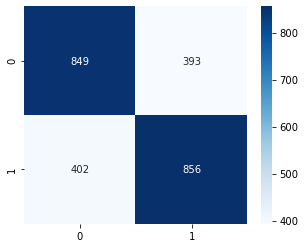

In [124]:
plt.figure(figsize=(5,4))
print(classification_report(y_test_Final, predictionsXGBoost))
sns.heatmap(confusion_matrix(y_test_Final, predictionsXGBoost), cmap = "Blues", annot=True, fmt = '.0f')

## Conclusion

The dataset that we have examined in this notebook is very different to the others that we have covered, due to it containing colour images of varying sizes, making the preprocessing of the images quite different. Also, the classifiers runtime as a whole was much slower than the previous notebooks, on account of the resulting dataset being so large.<br>

We made the decision not to run the classifiers before the use of PCA, as I consider it to be a waste of resources when the PCA covers so much of the variance, hence resulting in (most likely) a quite low difference in accuracy. That said, using the classifiers before PCA should result in better accuracies, so if one were to be pressed for accuracy, this would be a viable option.

Despite this, we have accomplished the task of building and training the classifiers available on 3 kinds of preprocessing of the data: once for grayscale images and once for coloured images, as well as once using clustering. We have also [chosen our best classifier](#bestclf) out of all: the XGBoost Classifier on coloured images with an accuracy of 0.6964 and a runtime of 493 seconds.

As a final step, we have run the best classifier on previously unseen data. The results of the run were not very good, but not too disappointing either: the runtime of the program did not change (almost, and the change can be due to change in resource availability for each task), but the accuracy dropped by roughly 2% to be 0.682. Although not totally unexpected, this is still a little disappointing.

Nevertheless, we have concluded the notebook with a score which is not bad, considering we did not use neural networks, which could dramatically boost the accuracy of the data.